# Text Classification:

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. 

In [363]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import nltk
import datetime
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D, concatenate, Embedding, Dropout, LeakyReLU
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

In [2]:
# https://stackoverflow.com/questions/48660547/how-can-i-extract-gpelocation-using-nltk-ne-chunk
def get_continuous_chunks(text, label):
    """ Function to implement chunking so we can get named entities and geograpphic locations"""
    chunked = nltk.ne_chunk(nltk.tag.pos_tag(nltk.word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked.subtrees():
        if type(subtree) == nltk.tree.Tree and subtree.label() == label:
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        if current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    return continuous_chunk

<pre>
Pre-processing steps:
-> We will extract emails from the given texts and remove them from the original text
-> We will extract subject from the given texts and remove them from the original text
-> Remove any sentences which start with From:, Write to:
-> Remove words within angular brackets ('< >'), '( )' brackets and between '_ _'
-> Remove all new line characters \n, tabs \t, '-', '\', digits, start or end with '_'
-> Remove words which end with ':'
-> Expand words to their full length - Decontractions
-> Chunking of text data - remove 'PERSON' and join words with '-' for GPE entities
-> Convert text to lower case and remove words gretaer than 15 and less than 2
-> Remove characters other than 'a-z_'
</pre>

In [13]:
def preprocess(Input_Text):
    """Do all the Preprocessing as shown above and
    return a tuple contain preprocess_email,preprocess_subject,preprocess_text for that Text_data"""
    
    text = Input_Text
    # email pre processing
    searchEmail = re.findall(r'\w+@[\w*\.]*', text)
    emails = []
    if searchEmail:
        for i in range(len(searchEmail)):
            temp = searchEmail[i].split('@')[1].split('.')
            for j in range(len(temp)):
                if not len(temp[j]) <= 2:
                    emails.append(temp[j])
        # replace email from input text with space
        text = Input_Text.replace(searchEmail[i],' ')
    processedEmail = ' '.join(emails)

    # pre processed subject
    subject1 = re.findall(r'Subject:.*\n', text)
    if subject1:
        subject1 = subject1[0]
        subject2 = re.sub(r'\w+:','',subject1)
        processedSubject = re.sub(r'[\n\t\r]','',re.sub(r'[^\w\s]','', subject2 )).strip(' ')
        # replace subject with space
        text = text.replace(subject1, ' ')
    else:
        processedSubject = ''
    
    # Delete all the sentences where a sentence starts with "Write to:" or "From:"
    text = re.sub(r'Write to:.*\n|From:.*\n',' ', text)
    
    # Delete all the tags like "< anyword >"
    text = re.sub(r'<.*>',' ', text)
    
    # Delete all the data which are present in the brackets
    text = re.sub(r'\(.*\)',' ', text)

    # Remove all the newlines('\n'), tabs('\t'), "-", "\"
    text = re.sub(r'\n',' ',text)
    text = re.sub(r'\t',' ',text)
    text = re.sub(r'-',' ',text)
    text = re.sub(r'\\',' ',text)

    # Remove all the words which ends with ":"
    text = re.sub(r'\w+:', ' ', text)

    # Decontractions, replace words to full words
    phrase = re.sub(r"won't", "will not", text)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    text = re.sub(r"\'m", " am", phrase)

    # Dechunk 
    dechunkGPE = get_continuous_chunks(text, 'GPE')
    dechunkPerson = get_continuous_chunks(text,'PERSON')
    if dechunkGPE:
        for ele in dechunkGPE:
            text = text.replace(ele,'_'.join(ele.split(' ')))

    if dechunkPerson:
        for ele in dechunkPerson:
            text = text.replace(ele,' ')

    # Replace all the digits with space 
    text = re.sub(r'\d',' ',text)

    # Remove '_words_', '_words', 'words_' from text
    underscore = re.findall(r'_\w+_', text)
    underscoreText = text
    if underscore:
        for ele in underscore:
            tempStrip = ele.strip('_')
            underscoreText = underscoreText.replace(ele, tempStrip)

    underscore = re.findall(r'_\w+',underscoreText )
    underscore.extend(re.findall(r'\w+_', underscoreText))
    if underscore:
        for ele in underscore:
            tempStrip = ele.strip('_')
            underscoreText = underscoreText.replace(ele, tempStrip)

    # Remove letters before underscore in 'oneLetter_words' and 'twoleter_words' 
    underscore = re.findall(r'\w{1,2}_\w+', underscoreText)
    if underscore:
        for ele in underscore:
            tempStrip = ele.split('_')
            underscoreText = underscoreText.replace(ele, tempStrip[1])

    # Convert whole text to lower case
    text = underscoreText.lower()
    
    # Remove words greater than or equal to 15 and less than or equa to 2
    text = re.sub(r'\w{15,}',' ',text)
    text = re.sub(r'\b\w{1,2}\b',' ',text)

    # replace all the words except "A-Za-z_" with space
    preprocessedText = re.sub(r'[^a-zA-Z_]',' ', text)
    
    preprocessedText = re.sub(' +', ' ', preprocessedText)
    preprocessedText = re.sub(',', ' ', preprocessedText)
    processedSubject = re.sub(' +', ' ', processedSubject)
    processedEmail = re.sub(' +', ' ', processedEmail)
    return (processedEmail,processedSubject,preprocessedText)

In [32]:
with open('documents/alt.atheism_49960.txt') as f:
    contents = f.read()
    email, subj, text = preprocess(contents)

In [15]:
print(contents)

From: mathew <mathew@mantis.co.uk>
Subject: Alt.Atheism FAQ: Atheist Resources

Archive-name: atheism/resources
Alt-atheism-archive-name: resources
Last-modified: 11 December 1992
Version: 1.0

                              Atheist Resources

                      Addresses of Atheist Organizations

                                     USA

FREEDOM FROM RELIGION FOUNDATION

Darwin fish bumper stickers and assorted other atheist paraphernalia are
available from the Freedom From Religion Foundation in the US.

Write to:  FFRF, P.O. Box 750, Madison, WI 53701.
Telephone: (608) 256-8900

EVOLUTION DESIGNS

Evolution Designs sell the "Darwin fish".  It's a fish symbol, like the ones
Christians stick on their cars, but with feet and the word "Darwin" written
inside.  The deluxe moulded 3D plastic fish is $4.95 postpaid in the US.

Write to:  Evolution Designs, 7119 Laurel Canyon #4, North Hollywood,
           CA 91605.

People in the San Francisco Bay area can get Darwin Fish from Lynn Gold

In [35]:
email

'mantis netcom com mantis'

In [33]:
subj

'AltAtheism Atheist Resources'

In [34]:
text

' archive atheism resources alt atheism archive resources last december atheist resources addresses atheist organizations usa freedom from religion foundation fish bumper stickers and assorted other atheist paraphernalia are available from the freedom from religion foundation the evolution designs evolution designs sell the fish fish symbol like the ones stick their cars but with feet and the word written inside the deluxe moulded plastic fish postpaid the people the san francisco bay area can get fish from try mailing for net people who directly the price per fish american atheist press aap publish various atheist books critiques the bible lists biblical contradictions and one such book the bible handbook and american atheist press isbn edition bible contradictions absurdities atrocities immoralities contains the bible contradicts itself aap based the king version the bible austin prometheus books sell books including holy horrors alternate address prometheus books african americans f

### Call preprocess function on all the texts in the document 

In [15]:
preprocessed_file = open('preprocessed_features.csv','w+')
preprocessed_file.write("class,preprocessed_text,preprocessed_subject,preprocessed_emails")
preprocessed_file.write("\n")

files = os.listdir('documents')

for file in files:
    if(file.endswith("txt")):
        class_label=file.split('_')[0]
        with open('documents/'+file) as fp:
            input_Text = fp.read()
            email, subj, text = preprocess(input_Text)
        fp.close()
    preprocessed_file.write(class_label+","+text+","+subj+","+email+"\n")

preprocessed_file.close()

In [2]:
# https://stackoverflow.com/questions/48812580/python-pandas-unicodedecodeerror-utf-8-codec-cant-decode-byte-0xcd-in-pos
processedDF = pd.read_csv('preprocessed_features.csv', encoding='ISO-8859-1')
processedDF.head(1)

,class,preprocessed_text,preprocessed_subject,preprocessed_emails
0,alt.atheism,archive atheism resources alt atheism archive...,AltAtheism Atheist Resources,mantis netcom com mantis


In [3]:
processedDF.shape

(18828, 4)

In [4]:
processedDF['class'].value_counts()

rec.sport.hockey            999
soc.religion.christian      997
rec.motorcycles             994
rec.sport.baseball          994
sci.crypt                   991
sci.med                     990
rec.autos                   990
sci.space                   987
comp.os.ms-windows.misc     985
comp.sys.ibm.pc.hardware    982
sci.electronics             981
comp.windows.x              980
comp.graphics               973
misc.forsale                972
comp.sys.mac.hardware       961
talk.politics.mideast       940
talk.politics.guns          910
alt.atheism                 799
talk.politics.misc          775
talk.religion.misc          628
Name: class, dtype: int64

## Training Model 1: Using 1D convolutions with word embeddings
<pre>
-> Combine the results of preprocess into a single column
-> Tokenise the data
-> Pad the sequence to get uniform number for all
-> Create Loss history callback for metrics including f1 score
-> Create callback for early stopping, scheduler- to dynamically change learning rate, TerminateNan - terminate when loss or weights become nan, Tensorboard - for visualizing metrics and weights
-> Model with Conv1D layers with kernel sizes - 3,4,5 and number of filters -32 
-> Layers with activation function-'relu' and kernel initializer - he_uniform
-> Output layer with softmax activation 
</pre>

In [5]:
processedDF['preprocessed_emails'] = processedDF['preprocessed_emails'].fillna('')

In [6]:
processedDF['combined_data'] = processedDF['preprocessed_text'] + processedDF['preprocessed_subject'] + processedDF['preprocessed_emails']
combined_data_df = processedDF[['combined_data']]
y = processedDF[['class']]

In [7]:
processedDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18828 entries, 0 to 18827
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   class                 18828 non-null  object
 1   preprocessed_text     18828 non-null  object
 2   preprocessed_subject  18828 non-null  object
 3   preprocessed_emails   18828 non-null  object
 4   combined_data         18828 non-null  object
dtypes: object(5)
memory usage: 735.6+ KB


In [20]:
labelModel = LabelEncoder()
labeled_y = labelModel.fit_transform(y)

In [218]:
from tensorflow.keras.utils import to_categorical
y_classes = to_categorical(labeled_y)

In [220]:
y_classes

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [265]:
X_train, X_test, y_train, y_test = train_test_split(combined_data_df, y_classes , test_size=0.25, random_state=45, stratify = y)

In [266]:
print(X_train.shape,'--------', X_test.shape)

(14121, 1) -------- (4707, 1)


In [306]:
model_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', oov_token='UNK')
model_tokenizer.fit_on_texts(X_train['combined_data'])

In [307]:
len(model_tokenizer.word_index)

88571

In [271]:
#model_tokenizer.word_index[model_tokenizer.oov_token] = max(model_tokenizer.word_index.values()) + 1

In [308]:
tokenized_train = model_tokenizer.texts_to_sequences(X_train['combined_data'])
tokenized_test = model_tokenizer.texts_to_sequences(X_test['combined_data'])

In [309]:
data_length = []
for i in range(len(tokenized_train)):
    data_length.append(len(tokenized_train[i]))

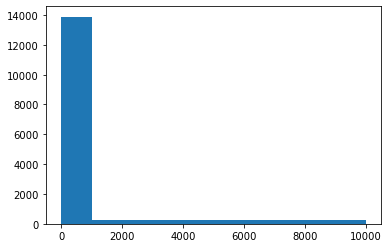

In [310]:
plt.hist(data_length, bins=[0,1000, 10000])
plt.show()

In [311]:
np.percentile(data_length,80)

231.0

In [312]:
data_length = np.asarray(data_length)
data_length[data_length > 230].shape

(2833,)

In [313]:
truncated_train= pad_sequences(tokenized_train, maxlen=230, padding='post')
truncated_test= pad_sequences(tokenized_test, maxlen=230, padding='post')

In [314]:
truncated_train = np.array(truncated_train, dtype='float')
truncated_test = np.array(truncated_test, dtype='float')

print(truncated_train.shape,'-------' ,truncated_test.shape)

(14121, 230) ------- (4707, 230)


In [374]:
#Reference: https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
# -> https://stackoverflow.com/questions/35365007/tensorflow-precision-recall-f1-score-and-confusion-matrix
def micro_f1(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    original_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = TP / (predicted_positives + K.epsilon())
    recall = TP / (original_positives + K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    y_p = tf.argmax(y_pred,1)
    y_t = tf.argmax(y_true,1)
    return f1_score(y_t, y_p)

In [394]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self, model, validation_data_x, validation_data_y):
        self.model = model
        self.validation_data_x = validation_data_x
        self.validation_data_y = validation_data_y        
    
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [], 'accuracy':[],'val_loss': [],'val_micro_f1': [], 'val_accuracy':[]}
        
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        val_predict = np.round(self.model.predict(self.validation_data_x))
        _val_f1 = f1_score(self.validation_data_y, val_predict, average='micro')
        logs['val_micro_f1'] = _val_f1
        print(logs)
        self.history['loss'].append(logs.get('loss'))
        #self.history['micro_f1'].append(logs.get('micro_f1'))
        self.history['accuracy'].append(logs.get('accuracy'))
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_accuracy',-1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        if logs.get('val_micro_f1', -1) != -1:
            self.history['val_micro_f1'].append(logs.get('val_micro_f1'))
                     

In [382]:
#Reference: https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/callbacks.py#L1215-L1221
# -> https://www.codespeedy.com/get_weights-and-set_weights-functions-in-keras-layers/

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Change in Learning rate 
def scheduler(epoch, lr):
    loss = history_own.history.get('loss')
    if len(loss) not in (0,1):
        if loss[epoch-1] < loss[epoch-2]:
            return lr*(1-0.1)
        elif not epoch%3:
            return lr * (1-0.05)**epoch
        else:
            return lr
    else:
        return lr

#Terminate on nan values of loss and/or weights
class TerminateNaN(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print("Invalid loss and terminated at epoch {}".format(epoch))
                self.model.stop_training = True
        for layer in self.model.layers:
            if len(layer.get_weights()) != 0:
                weights = layer.get_weights()[0]
                if np.isnan(weights).any() or np.isinf(weights).any():
                    self.model.stop_training = True
                

In [26]:
import os , signal
os.chdir("C:/Users/lokes/anaconda3")
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

In [27]:
%load_ext tensorboard

In [28]:
embeddings_index = dict()
f = open('M:/doc classification/glove.6B/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [315]:
embedding_matrix = np.zeros((len(model_tokenizer.word_index)+1, 100))
for word, i in model_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Model: "functional_93"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 230)]        0                                            
__________________________________________________________________________________________________
embedding_47 (Embedding)        (None, 230, 100)     8857200     input_48[0][0]                   
__________________________________________________________________________________________________
conv1d_280 (Conv1D)             (None, 230, 32)      9632        embedding_47[0][0]               
__________________________________________________________________________________________________
conv1d_281 (Conv1D)             (None, 230, 32)      12832       embedding_47[0][0]               
______________________________________________________________________________________

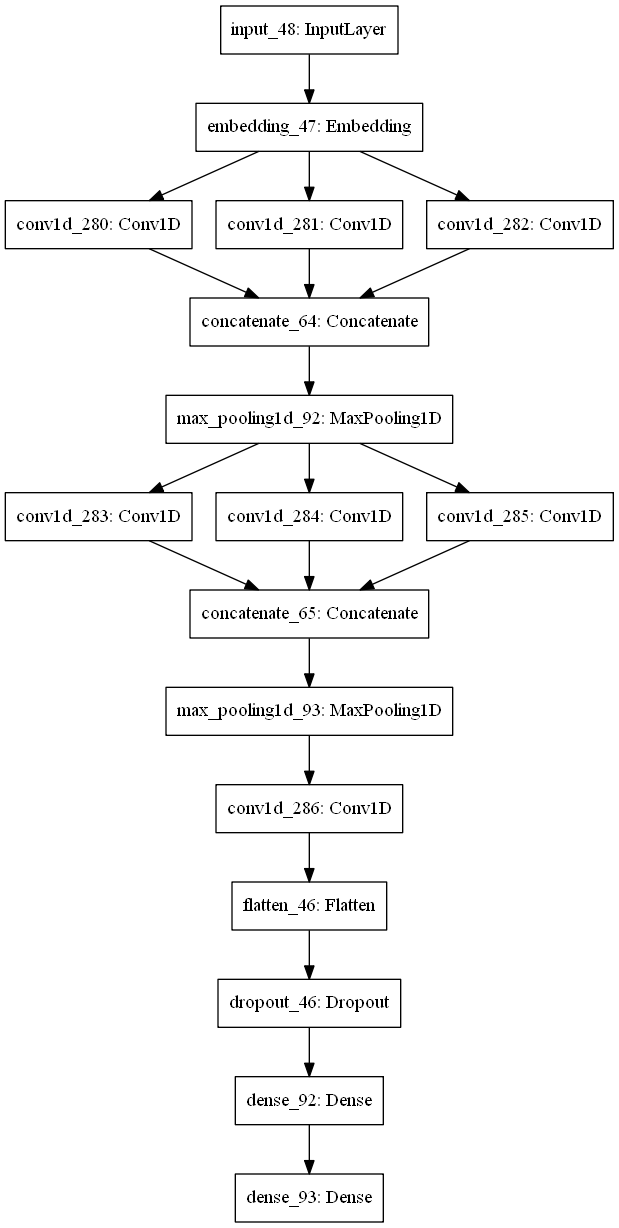

In [511]:
inputLayer = Input(shape=(230,))
embeddingLayer = Embedding(len(model_tokenizer.word_index)+1, output_dim= 100, input_length =230, weights=[embedding_matrix], trainable=False)(inputLayer)
conv1D_filter1 = Conv1D(filters=32, kernel_size =3, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(embeddingLayer)
conv1D_filter2 = Conv1D(filters=32, kernel_size =4, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(embeddingLayer)
conv1D_filter3 = Conv1D(filters=32, kernel_size =5, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(embeddingLayer)
concatenate1 = concatenate([conv1D_filter1,conv1D_filter2,conv1D_filter3])
maxpool1 = MaxPool1D(3)(concatenate1)

conv1D_filter4 = Conv1D(filters=32, kernel_size =3, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(maxpool1)
conv1D_filter5 = Conv1D(filters=32, kernel_size =4, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(maxpool1)
conv1D_filter6 = Conv1D(filters=32, kernel_size =5, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(maxpool1)
concatenate2 = concatenate([conv1D_filter4,conv1D_filter5,conv1D_filter6])
maxpool2 = MaxPool1D(3)(concatenate2)

conv1D_filter7 = Conv1D(filters=16, kernel_size =5, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(maxpool2)
flatten1 = Flatten()(conv1D_filter7)

dropoutLayer = Dropout(0.2)(flatten1)
DenseLayer = Dense(8,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dropoutLayer)
outputLayer = Dense(20,activation='softmax',kernel_initializer=tf.keras.initializers.he_uniform())(DenseLayer)

model1 = Model(inputs=inputLayer, outputs=outputLayer)
print(model1.summary())

# plot graph
plot_model(model1, to_file='model_1.png')

In [512]:
#history_own = LossHistory()

# Stops when val_loss is not improved for 4 consecutive epochs
earlystop = EarlyStopping(monitor='val_loss', patience=4)

learningRate = LearningRateScheduler(scheduler, verbose=1)

termnateFun = TerminateNaN()

# Save model if its better than previous epoch
filepath="model_save/best_model_1-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [513]:
history_own = LossHistory(model1,truncated_train,y_train )
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.8)

model1.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

model1.fit(truncated_train,y_train,epochs=25, validation_data=(truncated_train,y_train), batch_size=200, callbacks=[history_own,earlystop,checkpoint, tensorboard_callback])

Epoch 1/25
71/71 [==============================] - ETA: 0s - loss: 2.9999 - accuracy: 0.0557{'loss': 2.9999332427978516, 'accuracy': 0.05566177889704704, 'val_loss': 2.978943109512329, 'val_accuracy': 0.0652928277850151, 'val_micro_f1': 0.0}

Epoch 00001: val_accuracy improved from -inf to 0.06529, saving model to model_save\best_model_1-01-0.0653.hdf5
71/71 [==============================] - 15s 207ms/step - loss: 2.9999 - accuracy: 0.0557 - val_loss: 2.9789 - val_accuracy: 0.0653
Epoch 2/25
71/71 [==============================] - ETA: 0s - loss: 2.9545 - accuracy: 0.0749{'loss': 2.9545042514801025, 'accuracy': 0.07492387294769287, 'val_loss': 2.884012460708618, 'val_accuracy': 0.09383188188076019, 'val_micro_f1': 0.0}

Epoch 00002: val_accuracy improved from 0.06529 to 0.09383, saving model to model_save\best_model_1-02-0.0938.hdf5
71/71 [==============================] - 14s 203ms/step - loss: 2.9545 - accuracy: 0.0749 - val_loss: 2.8840 - val_accuracy: 0.0938
Epoch 3/25
71/71 [==

Epoch 17/25
71/71 [==============================] - ETA: 0s - loss: 1.0405 - accuracy: 0.6255{'loss': 1.040536880493164, 'accuracy': 0.625522255897522, 'val_loss': 0.9565848708152771, 'val_accuracy': 0.6479710936546326, 'val_micro_f1': 0.6170931916948333}

Epoch 00017: val_accuracy did not improve from 0.66723
71/71 [==============================] - 14s 193ms/step - loss: 1.0405 - accuracy: 0.6255 - val_loss: 0.9566 - val_accuracy: 0.6480
Epoch 18/25
71/71 [==============================] - ETA: 0s - loss: 0.9675 - accuracy: 0.6497{'loss': 0.9674874544143677, 'accuracy': 0.6496707201004028, 'val_loss': 0.8591806292533875, 'val_accuracy': 0.6924439072608948, 'val_micro_f1': 0.6525445846020008}

Epoch 00018: val_accuracy improved from 0.66723 to 0.69244, saving model to model_save\best_model_1-18-0.6924.hdf5
71/71 [==============================] - 14s 192ms/step - loss: 0.9675 - accuracy: 0.6497 - val_loss: 0.8592 - val_accuracy: 0.6924
Epoch 19/25
71/71 [=============================

In [522]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 14688), started 0:01:53 ago. (Use '!kill 14688' to kill it.)

In [514]:
history_own.history

{'loss': [2.9999332427978516,
  2.9545042514801025,
  2.8249690532684326,
  2.653808832168579,
  2.500009775161743,
  2.359276533126831,
  2.3185770511627197,
  2.1167190074920654,
  1.9174376726150513,
  1.7279071807861328,
  1.5639729499816895,
  1.4289131164550781,
  1.315038800239563,
  1.2624030113220215,
  1.1470558643341064,
  1.0871689319610596,
  1.040536880493164,
  0.9674874544143677,
  0.9022698998451233,
  0.8569797277450562,
  0.8278325796127319,
  0.7811964154243469,
  0.7147268652915955,
  0.6759369969367981,
  0.6473155617713928],
 'accuracy': [0.05566177889704704,
  0.07492387294769287,
  0.09850577265024185,
  0.1295234113931656,
  0.16252389550209045,
  0.19141703844070435,
  0.20628850162029266,
  0.27143970131874084,
  0.31874513626098633,
  0.38070958852767944,
  0.43750444054603577,
  0.4877133369445801,
  0.5338857173919678,
  0.5482614636421204,
  0.5901139974594116,
  0.6065434217453003,
  0.625522255897522,
  0.6496707201004028,
  0.6733942627906799,
  0.691

In [515]:
results_1 = model1.evaluate(truncated_test,y_test)

148/148 [==============================] - 1s 6ms/step - loss: 1.1530 - accuracy: 0.6467


In [516]:
results_1

[1.152989149093628, 0.6466963887214661]

In [517]:
pred_y_test = np.round(model1.predict(truncated_test))
model1_f1 = f1_score(y_test, pred_y_test, average='micro')

In [520]:
model1_f1

0.6432062561094819

### Training Model-2 : Using 1D convolutions with character embedding

<pre>
-> Tokenising using character embedding
</pre>

In [110]:
chars = list('abcdefghijklmnopqrstuvwxyz-')

In [227]:
char_indices = dict((c, i+1) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [221]:
y_classes

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [222]:
X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(combined_data_df, y_classes , test_size=0.25, random_state=45, stratify = y)

print(X_train_char.shape,'--------', X_test_char.shape)

(14121, 1) -------- (4707, 1)


In [224]:
model_char_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', char_level=True)
model_char_tokenizer.fit_on_texts(X_train_char['combined_data'])

In [229]:
model_char_tokenizer.word_index = char_indices.copy()

In [230]:
tokenized_char_train = model_char_tokenizer.texts_to_sequences(X_train_char['combined_data'])
tokenized_char_test = model_char_tokenizer.texts_to_sequences(X_test_char['combined_data'])

In [234]:
char_data_length = []
for i in range(len(tokenized_char_train)):
    char_data_length.append(len(tokenized_char_train[i]))

In [237]:
np.percentile(char_data_length,80)

1184.0

In [239]:
truncated_char_train= pad_sequences(tokenized_char_train, maxlen=1184, padding='post')
truncated_char_test= pad_sequences(tokenized_char_test, maxlen=1184, padding='post')

In [240]:
truncated_char_train = np.array(truncated_char_train, dtype='float')
truncated_char_test = np.array(truncated_char_test, dtype='float')

In [242]:
print(truncated_char_train.shape,'-------' ,truncated_char_test.shape)

(14121, 1184) ------- (4707, 1184)


In [187]:
file_path = "M:/doc classification/glove.6B/glove.6B.100d.txt"

vectors = {}
i = 0
with open(file_path, 'rb') as f:
    for line in f:
        line_split = str(line,'UTF-8').strip().split(" ")
        vec = np.array(list(map(float, line_split[1:])))
        word = line_split[0]
        i +=1

        for char in word:
            if ord(char) < 128:
                if char in vectors:
                    vectors[char] = (vectors[char][0] + vec,
                                     vectors[char][1] + 1)
                else:
                    vectors[char] = (vec, 1)

In [191]:
vectors.keys()

dict_keys(['t', 'h', 'e', ',', '.', 'o', 'f', 'a', 'n', 'd', 'i', '"', "'", 's', 'r', '-', 'w', 'b', 'y', '(', ')', 'm', '`', 'v', 'u', 'c', 'l', ':', 'p', 'g', '$', ';', '_', 'k', 'j', '1', 'x', '?', '0', '2', 'q', '%', '/', '3', '5', '4', '8', '6', '7', '9', '&', 'z', '!', '=', '#', '[', '+', '|', ']', '~', '\\', '{', '>', '}', '*', '@', '<', '^'])

In [195]:
file_path2 = "M:/doc classification/glove_char_vectors.txt"
with open(file_path2, 'w') as f2:
    for word in vectors:
        avg_vector = np.round(
            (vectors[word][0] / vectors[word][1]), 6).tolist()
        f2.write(word + " " + " ".join(str(x) for x in avg_vector) + "\n")

In [196]:
embedding_char_vectors = {}
with open("M:/doc classification/glove_char_vectors.txt", 'r') as f:
    for line in f:
        line_split = line.strip().split(" ")
        vec = np.array(line_split[1:], dtype=float)
        char = line_split[0]
        embedding_char_vectors[char] = vec

embedding_char_matrix = np.zeros((len(chars), 100))

for char, i in char_indices.items():
    embedding_char_vector = embedding_char_vectors.get(char)
    if embedding_char_vector is not None:
        embedding_char_matrix[i] = embedding_char_vector

Model: "functional_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 1184)]            0         
_________________________________________________________________
embedding_50 (Embedding)     (None, 1184, 100)         2700      
_________________________________________________________________
conv1d_295 (Conv1D)          (None, 1184, 32)          16032     
_________________________________________________________________
conv1d_296 (Conv1D)          (None, 1184, 32)          5152      
_________________________________________________________________
max_pooling1d_98 (MaxPooling (None, 236, 32)           0         
_________________________________________________________________
conv1d_297 (Conv1D)          (None, 236, 16)           2576      
_________________________________________________________________
conv1d_298 (Conv1D)          (None, 236, 16)         

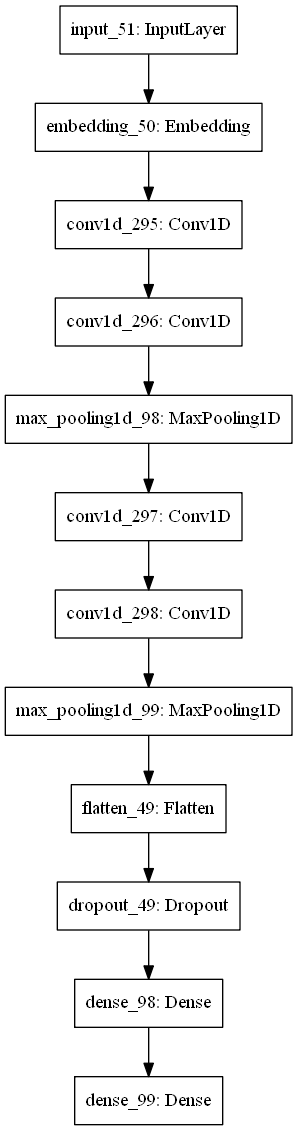

In [531]:
inputLayer_2 = Input(shape=(1184,))
embeddingLayer_2 = Embedding(len(chars), output_dim= 100, input_length =1184, weights=[embedding_char_matrix], trainable=False)(inputLayer_2)
conv1D_filter1_2 = Conv1D(filters=32, kernel_size =5, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(embeddingLayer_2)
conv1D_filter2_2 = Conv1D(filters=32, kernel_size =5, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(conv1D_filter1_2)
maxpool1_2 = MaxPool1D(5)(conv1D_filter2_2)

conv1D_filter3_2 = Conv1D(filters=16, kernel_size =5, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(maxpool1_2)
conv1D_filter4_2 = Conv1D(filters=16, kernel_size =5, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_uniform())(conv1D_filter3_2)
maxpool2_2 = MaxPool1D(5)(conv1D_filter4_2)

flatten1_2 = Flatten()(maxpool2_2)

dropoutLayer_2 = Dropout(0.4)(flatten1_2)
DenseLayer_2 = Dense(8,activation='relu',kernel_initializer=tf.keras.initializers.he_uniform())(dropoutLayer_2)
outputLayer_2 = Dense(20,activation='sigmoid',kernel_initializer=tf.keras.initializers.he_uniform())(DenseLayer_2)

model2 = Model(inputs=inputLayer_2, outputs=outputLayer_2)
print(model2.summary())

plot_model(model2, to_file='model_2.png')

In [532]:
#history_own = LossHistory()

# Stops when val_loss is not improved for 2 consecutive epochs
earlystop = EarlyStopping(monitor='val_loss', patience=2)

learningRate = LearningRateScheduler(scheduler, verbose=1)

termnateFun = TerminateNaN()

# Save model if its better than previous epoch
filepath="model_save/best_model_2-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [533]:
history_own = LossHistory(model2,truncated_char_train,y_train_char )
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)

model2.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

model2.fit(truncated_char_train,y_train_char,epochs=10, validation_data=(truncated_char_train,y_train_char), batch_size=100, callbacks=[history_own,earlystop,learningRate,checkpoint,termnateFun, tensorboard_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 1/10
141/142 [============================>.] - ETA: 0s - loss: 2.9933 - accuracy: 0.0586{'loss': 2.99324893951416, 'accuracy': 0.05856525897979736, 'val_loss': 2.9887657165527344, 'val_accuracy': 0.055236879736185074, 'val_micro_f1': 0.10408407677577604}

Epoch 00001: val_accuracy improved from -inf to 0.05524, saving model to model_save\best_model_2-01-0.0552.hdf5
142/142 [==============================] - 30s 214ms/step - loss: 2.9932 - accuracy: 0.0586 - val_loss: 2.9888 - val_accuracy: 0.0552

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 2/10
141/142 [============================>.] - ETA: 0s - loss: 2.9866 - accuracy: 0.0565{'loss': 2.9865798950195312, 'accuracy': 0.05644076317548752, 'val_loss': 2.9829885959625244, 'val_accuracy': 0.07180794328451157, 'val_micro_f1': 0.10900338128259499}

Epoch 00002: val_accuracy improved from 0.05524 to 0.07181,

In [536]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 14688), started 0:40:00 ago. (Use '!kill 14688' to kill it.)

In [534]:
history_own.history

{'loss': [2.99324893951416,
  2.9865798950195312,
  2.9803810119628906,
  2.9750900268554688,
  2.9722440242767334,
  2.970442771911621,
  2.9679923057556152,
  2.9654059410095215,
  2.963491201400757,
  2.961968421936035],
 'accuracy': [0.05856525897979736,
  0.05644076317548752,
  0.06706324219703674,
  0.06940018385648727,
  0.06961263716220856,
  0.06784222275018692,
  0.06734650582075119,
  0.0689752846956253,
  0.07003753632307053,
  0.0695418193936348],
 'val_loss': [2.9887657165527344,
  2.9829885959625244,
  2.975148916244507,
  2.9739179611206055,
  2.9681711196899414,
  2.966162919998169,
  2.965979814529419,
  2.9649579524993896,
  2.9618022441864014,
  2.95858097076416],
 'val_micro_f1': [0.10408407677577604,
  0.10900338128259499,
  0.10821297405056093,
  0.10813509430536913,
  0.10861631481730036,
  0.10872406170230957,
  0.10860711376595167,
  0.10858861480996385,
  0.10876063601722297,
  0.10900261577213718],
 'val_accuracy': [0.055236879736185074,
  0.0718079432845115

In [537]:
results_2 = model2.evaluate(truncated_char_test,y_test_char)

148/148 [==============================] - 2s 11ms/step - loss: 2.9527 - accuracy: 0.0718


In [538]:
results_2

[2.9526712894439697, 0.07180794328451157]

In [535]:
pred_y_test_char = np.round(model2.predict(truncated_char_test))
model2_f1 = f1_score(y_test_char, pred_y_test_char, average='micro')
print(model2_f1)

0.11049183887662407


In [543]:
results_1.append(model1_f1)
results_2.append(model2_f1)

[1.152989149093628, 0.6466963887214661, 0.6432062561094819]

In [544]:
loss_table = pd.DataFrame([results_1, results_2], columns=['Loss','Accuracy' ,'f1 score'], index=['Model-1','Model-2'])

In [545]:
loss_table

,Loss,Accuracy,f1 score
Model-1,1.152989,0.646696,0.643206
Model-2,2.952671,0.071808,0.110492


Model 1 has better loss, accuracy and f1 score compared to model 2.

And model 1 took less time to train on 